<a href="https://colab.research.google.com/github/villeneuvevincent/POLIMI_AI/blob/main/customedCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Project AI Biomedicine

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/10EKDnEIJjWBjPSRVYY0s4V9tyfD5cI8a/Project AI Biomedicine


## 📚 Import Librairies

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import random
import numpy as np

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seeds for random number generators in NumPy and Python and TensorFlow
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
import logging
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Print TensorFlow version
print("TensorFlow version : ",tf.__version__)

# Import other libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

TensorFlow version :  2.18.0


## ⏭ Load Data

In [ ]:
import pickle

# Load the dataset
with open('new_balanced_224_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

print("new_balanced_224_dataset loaded successfully.")

new_balanced_224_dataset loaded successfully.


In [ ]:
print(dataset.shape)
dataset.head()

(3963, 5)


,patient_id,tumor_class,tumor_type,full_images,nodule_images
0,pat434,2,Bénin,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0446864438603079], [0.0446864438603079], ..."
1,pat733,3,Bénin,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.4241748438893845], [0.4241748438893845], ..."
2,pat1886,1,Bénin,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.23274161735700194], [0.23274161735700194]..."
3,pat4,5,Malin,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.026962727993655844], [0.02166647785204485..."
4,pat1417,3,Bénin,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.4095199015182601], [0.4095199015182601], ..."


## 🔍 Inspect Data

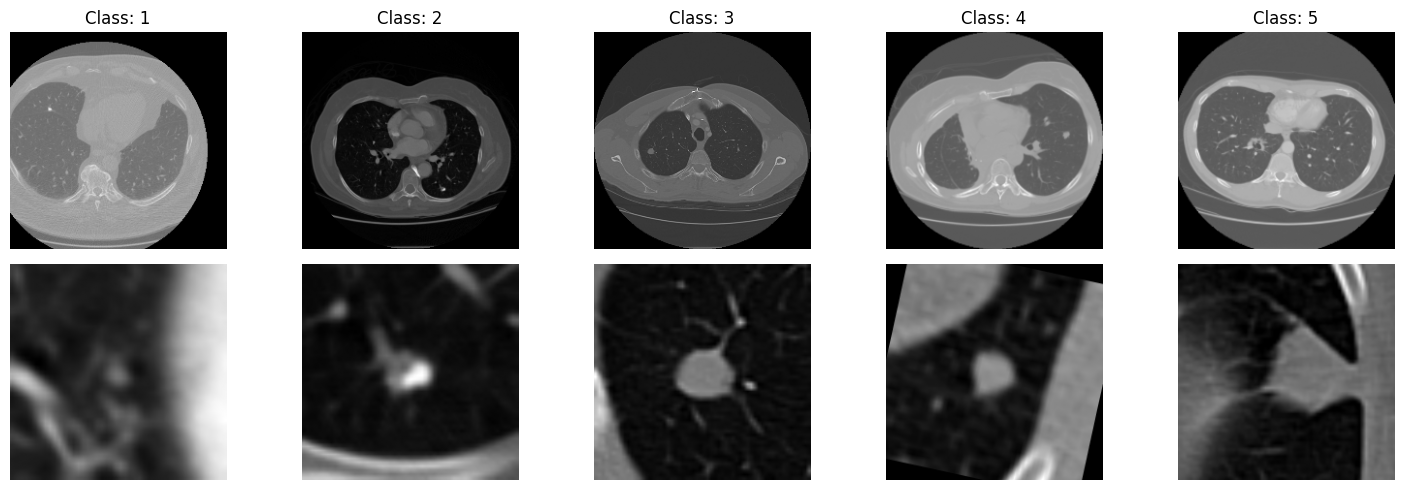

In [ ]:
def plot_images(datasetClass, dataset1, dataset2):
  unique_classes = np.unique(datasetClass)
  selected_indices = []

  for c in unique_classes:
      for i in range(len(datasetClass)):
          if datasetClass[i] == c:
              selected_indices.append(i)
              break

  plt.figure(figsize=(15, 5))
  for idx, i in enumerate(selected_indices):
      plt.subplot(2, len(unique_classes), idx + 1)
      plt.imshow(dataset1[i], cmap='gray')
      plt.axis('off')
      plt.title(f"Class: {datasetClass[i]}")

      plt.subplot(2, len(unique_classes), idx + 1 + len(unique_classes))
      plt.imshow(dataset2[i], cmap='gray')
      plt.axis('off')

  plt.tight_layout()
  plt.show()

  return None

plot_images(dataset['tumor_class'], dataset['full_images'], dataset['nodule_images'])

## 📈 Preprocess

In [ ]:
# Separate images and labels from the filtered dataset
full_images = np.stack(np.array(dataset['full_images'])).astype(np.float32)  # Full images
zoomed_images = np.stack(np.array(dataset['nodule_images'])).astype(np.float32)  # Zoomed-in images of nodules
tumor_classes = dataset['tumor_class']  # Tumor classes (1 to 5)
tumor_types = dataset['tumor_type']  # Type of tumor (malignant or benign)

# Converting classes into binary and multi-class labels
binary_labels = np.array([1 if label == "Malin" else 0 for label in tumor_types])  # Benign = 0, Malignant = 1
multi_class_labels = np.array(tumor_classes) - 1  # TumorClass as label for multi-class classification (0-4)

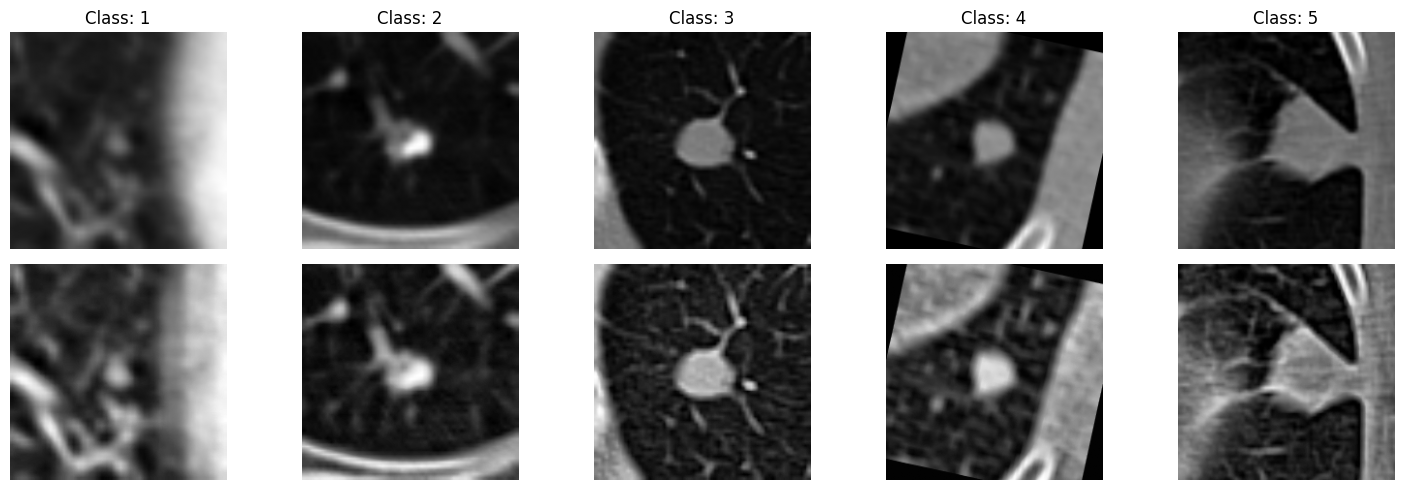

In [ ]:
import cv2
import numpy as np

# Apply to a batch of images
def process_images(images):
    processed_images = []

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for img in images:
        # Convert to uint8
        if img.max() <= 1:
            blurred = (img * 255).astype(np.uint8)

        # Apply CLAHE
        result = clahe.apply(blurred)

        # 0-1
        result = result / 255.0

        # Gray Channel
        result = np.expand_dims(result, axis=-1)

        processed_images.append(result)

    return np.array(processed_images)

# Process full_images and zoomed_images
processed_full_images = process_images(full_images)
processed_zoomed_images = process_images(zoomed_images)

plot_images(tumor_classes, zoomed_images, processed_zoomed_images)

## 🧮 Train-Validation Split

In [ ]:
'''
Training on full images in binary classification
'''
X_train_f , X_testset , y_train_f , y_testset = train_test_split(full_images,
                                                              binary_labels,
                                                              test_size=0.3,
                                                              random_state=42
)

X_test_f, X_val_f, y_test_f, y_val_f = train_test_split(X_testset,
                                                  y_testset,
                                                  test_size=0.5,
                                                  random_state=42
)

'''
Training on nodules images in binary classification
'''
X_train_n , X_testset , y_train_n , y_testset = train_test_split(zoomed_images,
                                                              binary_labels,
                                                              test_size=0.3,
                                                              random_state=42
)

X_test_n, X_val_n, y_test_n, y_val_n = train_test_split(X_testset,
                                                  y_testset,
                                                  test_size=0.5,
                                                  random_state=42
)

In [ ]:
print(" === MULTI LABEL CLASSIFICATION ===")
print(f"X_train shape: {X_train_f.shape} [{type(X_train_f)} , {X_train_f.dtype}] / y_train shape: {y_train_f.shape} [{type(y_train_f)}]")
print(f"X_val shape: {X_val_f.shape} [{type(X_val_f)} , {X_val_f.dtype}] / y_val shape: {y_val_f.shape} [{type(y_val_f)}]")
print(f"X_test shape: {X_test_f.shape} [{type(X_test_f)} , {X_test_f.dtype}] / y_test shape: {y_test_f.shape} [{type(y_test_f)}]")

print(" === BINARY CLASSIFICATION ===")
print(f"X_train shape: {X_train_n.shape} [{type(X_train_n)} , {X_train_n.dtype}] / y_train shape: {y_train_n.shape} [{type(y_train_n)}]")
print(f"X_val shape: {X_val_n.shape} [{type(X_val_n)} , {X_val_n.dtype}] / y_val shape: {y_val_n.shape} [{type(y_val_n)}]")
print(f"X_test shape: {X_test_n.shape} [{type(X_test_n)} , {X_test_n.dtype}] / y_test shape: {y_test_n.shape} [{type(y_test_n)}]")

 === MULTI LABEL CLASSIFICATION ===
X_train shape: (2774, 224, 224, 1) [<class 'numpy.ndarray'> , float32] / y_train shape: (2774,) [<class 'numpy.ndarray'>]
X_val shape: (595, 224, 224, 1) [<class 'numpy.ndarray'> , float32] / y_val shape: (595,) [<class 'numpy.ndarray'>]
X_test shape: (594, 224, 224, 1) [<class 'numpy.ndarray'> , float32] / y_test shape: (594,) [<class 'numpy.ndarray'>]
 === BINARY CLASSIFICATION ===
X_train shape: (2774, 224, 224, 1) [<class 'numpy.ndarray'> , float32] / y_train shape: (2774,) [<class 'numpy.ndarray'>]
X_val shape: (595, 224, 224, 1) [<class 'numpy.ndarray'> , float32] / y_val shape: (595,) [<class 'numpy.ndarray'>]
X_test shape: (594, 224, 224, 1) [<class 'numpy.ndarray'> , float32] / y_test shape: (594,) [<class 'numpy.ndarray'>]


## 🏋 Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_f), y=y_train_f)

class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.7650303364589078, 1: 1.4432882414151924}


## 🧮 PARAMETERS

In [ ]:
# Input parameters
INPUT_SHAPE = X_train_f.shape[1:]

# Output shape for the model
NUM_CLASS = np.unique(y_train_f).shape[0]


LEARNING_RATE = 1e-4
BATCH_SIZE = 16
EPOCHS = 200

print("Input Shape:", INPUT_SHAPE)
print("Output Shape:", NUM_CLASS)

Input Shape: (224, 224, 1)
Output Shape: 2


## ⚒ Create the Model

### Improved CNN

In [ ]:
'''
  Network developed in : Research on the Classification of Benign and Malignant Parotid Tumors Based on Transfer Learning and a Convolutional Neural Network
'''
def IMCNN(input_shape, learning_rate, task_type="multi-class"):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape,name='input')

    # Bloc 1: DepthConv + BN + ReLU + Pooling
    x = tfkl.DepthwiseConv2D((3, 3), padding='same', name='depthwise_conv_1')(input_layer)
    x = tfkl.BatchNormalization(name='BN_11')(x)
    x = tfkl.Activation('relu', name="Act_11")(x)
    x = tfkl.Conv2D(64, (1, 1), padding='same', kernel_initializer=tfk.initializers.HeNormal(42), name='conv_1')(x)
    x = tfkl.BatchNormalization(name='BN_12')(x)
    x = tfkl.Activation('relu', name="Act_12")(x)
    x = tfkl.MaxPooling2D((2, 2), name='pool_1')(x)

    # Bloc 2:
    x = tfkl.Conv2D(128, (3, 3), padding='same', kernel_initializer=tfk.initializers.HeNormal(42), name='conv_2')(x)
    x = tfkl.BatchNormalization(name='BN_21')(x)
    x = tfkl.Activation('relu', name="Act_21")(x)
    x = tfkl.MaxPooling2D((2, 2), name='pool_2')(x)

    # Bloc 3 parallele
    branch_11 = tfkl.Conv2D(256, (3, 3), padding='same', kernel_initializer=tfk.initializers.HeNormal(42), name='conv_31')(x)
    branch_11 = tfkl.BatchNormalization(name='BN_31')(branch_11)
    branch_11 = tfkl.Activation('relu', name="Act_31")(branch_11)

    branch_12 = tfkl.Conv2D(256, (3, 3), padding='same', kernel_initializer=tfk.initializers.HeNormal(42), name='conv_32')(x)
    branch_12 = tfkl.BatchNormalization(name='BN_32')(branch_12)
    branch_12 = tfkl.Activation('relu', name="Act_32")(branch_12)

    x = tfkl.concatenate([branch_11, branch_12], name='concat_pool_3')
    x = tfkl.MaxPooling2D((2, 2), name='pool_3')(x)

    # Bloc 4 parallele
    branch_21 = tfkl.Conv2D(512, (3, 3), padding='same', kernel_initializer=tfk.initializers.HeNormal(42), name='conv_41')(x)
    branch_21 = tfkl.BatchNormalization(name='BN_41')(branch_21)
    branch_21 = tfkl.Activation('relu', name="Act_41")(branch_21)

    branch_22 = tfkl.Conv2D(512, (3, 3), padding='same', kernel_initializer=tfk.initializers.HeNormal(42), name='conv_42')(x)
    branch_22 = tfkl.BatchNormalization(name='BN_42')(branch_22)
    branch_22 = tfkl.Activation('relu', name="Act_42")(branch_22)

    branch_23 = tfkl.Conv2D(512, (3, 3), padding='same', kernel_initializer=tfk.initializers.HeNormal(42), name='conv_43')(x)
    branch_23 = tfkl.BatchNormalization(name='BN_43')(branch_23)
    branch_23 = tfkl.Activation('relu', name="Act_43")(branch_23)

    x = tfkl.concatenate([branch_21, branch_22, branch_23], name='concat_pool_4')
    x = tfkl.MaxPooling2D((2, 2), name='pool_4')(x)

    # Classification
    x = tfkl.Flatten(name='flatten')(x)
    x = tfkl.Dense(512, activation='relu', kernel_initializer=tfk.initializers.HeNormal(42), name='dense')(x)
    x = tfkl.Dropout(0.3, name='dropout')(x)

    if task_type == "multi-class":
      output_shape = 5
    else:
      output_shape = 2
    output_activation = "softmax"
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    output_layer = tfkl.Dense(output_shape, activation=output_activation, kernel_initializer=tfk.initializers.LecunNormal(42), name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='imcnn')

    # Compile the model
    model.compile(loss=loss_fn, optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
imcnn = IMCNN(input_shape=INPUT_SHAPE, learning_rate=LEARNING_RATE, task_type="binary")
imcnn.summary(show_trainable=True)

Model: "imcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input (InputLayer)     │ (None, 224, 224, 1)  │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ depthwise_conv_1       │ (None, 224, 224, 1)  │           10 │ input[0][0]         │    Y    │
│ (DepthwiseConv2D)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ BN_11                  │ (None, 224, 224, 1)  │            4 │ depthwise_conv_1[0… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Act_11 (Activation)    │ (None, 224, 224, 1)  │            0 │ BN_11[0][0]         │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv_1 (Conv2D)        │ (None, 224, 224, 64) │          128 │ Act_11[0][0]        │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ BN_12                  │ (None, 224, 224, 64) │          256 │ conv_1[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Act_12 (Activation)    │ (None, 224, 224, 64) │            0 │ BN_12[0][0]         │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool_1 (MaxPooling2D)  │ (None, 112, 112, 64) │            0 │ Act_12[0][0]        │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv_2 (Conv2D)        │ (None, 112, 112,     │       73,856 │ pool_1[0][0]        │    Y    │
│                        │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ BN_21                  │ (None, 112, 112,     │          512 │ conv_2[0][0]        │    Y    │
│ (BatchNormalization)   │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Act_21 (Activation)    │ (None, 112, 112,     │            0 │ BN_21[0][0]         │    -    │
│                        │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool_2 (MaxPooling2D)  │ (None, 56, 56, 128)  │            0 │ Act_21[0][0]        │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv_31 (Conv2D)       │ (None, 56, 56, 256)  │      295,168 │ pool_2[0][0]        │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv_32 (Conv2D)       │ (None, 56, 56, 256)  │      295,168 │ pool_2[0][0]        │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ BN_31                  │ (None, 56, 56, 256)  │        1,024 │ conv_31[0][0]       │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ BN_32                  │ (None, 56, 56, 256)  │        1,024 │ conv_32[0][0]       │    Y    │
│ (BatchNormalization) 

 Total params: 161,894,928 (617.58 MB)

 Trainable params: 161,890,446 (617.56 MB)

 Non-trainable params: 4,482 (17.51 KB)

## 🏃 Train the Model

In [ ]:
patience = 10

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Create a ReduceOnPlateau Callback
reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Store the callback in a list
callbacks = [early_stopping, reduce_plateau]

### FULL IMAGE

In [ ]:
# Train IMCNN
history = imcnn.fit(
    X_train_f,
    tfk.utils.to_categorical(y_train_f),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_f, tfk.utils.to_categorical(y_val_f)),
    callbacks=callbacks,
    class_weight=class_weights
).history

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - accuracy: 0.5499 - loss: 8.1338 - val_accuracy: 0.3311 - val_loss: 1.0770 - learning_rate: 1.0000e-04
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5789 - loss: 0.6809 - val_accuracy: 0.3311 - val_loss: 0.8372 - learning_rate: 1.0000e-04
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6023 - loss: 0.6684 - val_accuracy: 0.5731 - val_loss: 0.6910 - learning_rate: 1.0000e-04
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6272 - loss: 0.6570 - val_accuracy: 0.6118 - val_loss: 0.6803 - learning_rate: 1.0000e-04
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6423 - loss: 0.6568 - val_accuracy: 0.6437 - val_loss: 0.6392 - learning_rate: 1.0000e-04
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6615 - loss: 0.6351 - val_accuracy: 0.6218 - val_loss: 0.6528 - learning_rate: 1.0000e-04
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/s

In [ ]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy Adam: {final_val_accuracy}%')

Final validation accuracy Adam: 71.76%


In [ ]:
# Save the trained model to a file, including final accuracy in the filename
model_filename = 'IMCNN_full_binary' + str(final_val_accuracy) + '.keras'
imcnn.save(model_filename)

In [ ]:
del imcnn

### NODULE IMAGES

In [ ]:
# Entrainement IMCNN bin
history = imcnn.fit(
    X_train_n,
    tfk.utils.to_categorical(y_train_n),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_n, tfk.utils.to_categorical(y_val_n)),
    callbacks=callbacks,
    class_weight=class_weights
).history

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.6589 - loss: 5.4246 - val_accuracy: 0.6807 - val_loss: 0.5700 - learning_rate: 1.0000e-04
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7839 - loss: 0.4821 - val_accuracy: 0.8101 - val_loss: 0.4215 - learning_rate: 1.0000e-04
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8209 - loss: 0.4309 - val_accuracy: 0.8185 - val_loss: 0.4019 - learning_rate: 1.0000e-04
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8303 - loss: 0.4045 - val_accuracy: 0.8168 - val_loss: 0.4282 - learning_rate: 1.0000e-04
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8375 - loss: 0.3824 - val_accuracy: 0.8151 - val_loss: 0.4136 - learning_rate: 1.0000e-04
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8692 - loss: 0.3244 - val_accuracy: 0.7899 - val_loss: 0.4784 - learning_rate: 1.0000e-04
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/st

In [ ]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy Adam: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'IMCNN_full_binary' + str(final_val_accuracy) + '.keras'
imcnn.save(model_filename)

del imcnn

Final validation accuracy Adam: 86.22%


## 🎓 Evaluate the Model

In [ ]:
'''
  Here we do the evaluation for the model train wit the nodule image
'''
model = tfk.models.load_model(model_filename)
print(model_filename)

IMCNN_full_binary86.22.keras


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score,confusion_matrix, ConfusionMatrixDisplay

def evaluate_model_performance_df(y_test, y_pred):
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred)

    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    precision_per_class = precision_score(y_true, y_pred, average=None)

    results_df = pd.DataFrame({
        "Classe": [f"Classe {i}" for i in range(len(recall_per_class))],
        "Recall": recall_per_class,
        "Precision": precision_per_class,
        "F1-score": f1_per_class,
    })


    accuracy_row = pd.DataFrame({
        "Classe": ["Accuracy globale"],
        "Recall": [accuracy],
        "Precision": [None],
        "F1-score": [None]
    })
    results_df = pd.concat([results_df, accuracy_row], ignore_index=True)

    return results_df.round(2)

def show_performance(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    results_df = evaluate_model_performance_df(tfk.utils.to_categorical(y_test), y_pred)
    return results_df

result = show_performance(X_test_n, y_test_n, model)
result

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


,Classe,Recall,Precision,F1-score
0,Classe 0,0.92,0.90,0.91
1,Classe 1,0.81,0.84,0.82
2,Accuracy globale,0.88,NaN,NaN


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


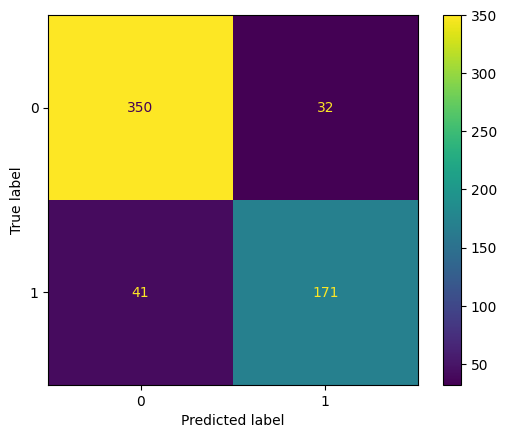

In [ ]:
from sklearn import metrics

def show_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    cm = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

    cm_display.plot()
    plt.show()

show_confusion_matrix(X_test_n, y_test_n, model)

In [ ]:
del model